In [2]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [3]:
%matplotlib inline

(5, 5)


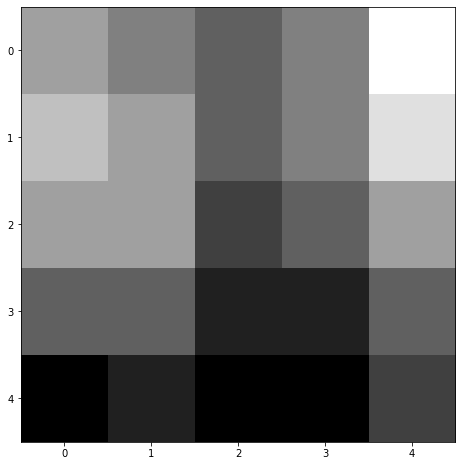

In [4]:
plt.figure(figsize=(20,8))
img = cv2.imread('./gen_data/5_gray/00_lenna.jpg', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

In [5]:
TRAIN_IMAGES = glob.glob('./gen_data/5_gray/*.jpg')
CLEAN_IMAGES = glob.glob('./gen_data/10_gray/*.jpg')
# TEST_IMAGES = glob.glob('../input/test/*.png')

In [9]:
def load_image(path, image_size = 5):
    image_list = np.zeros((len(path), image_size, image_size, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(image_size, image_size))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [10]:
x_train = load_image(TRAIN_IMAGES, 5)
y_train = load_image(CLEAN_IMAGES, 10)
# x_test = load_image(TEST_IMAGES)

print(x_train.shape, y_train.shape)

(2437, 5, 5, 1) (2437, 10, 10, 1)


In [11]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(1949, 5, 5, 1) (488, 5, 5, 1)


In [12]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 5
        self.img_cols = 5
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
#         h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 5, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 64)          640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 1)         577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________
Train on 1949 samples, validate on 488 samples
Epoch 1/200
1949/1949 [==============================] - 2s 1ms/sample - los

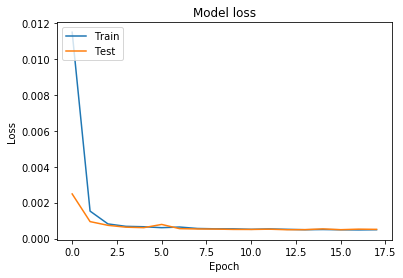

In [13]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=200, batch_size=20)

In [14]:
TEST_IMAGES = glob.glob('./gen_data/test/*.jpg')
x_test = load_image(TEST_IMAGES)
print(x_test.shape)

(10, 5, 5, 1)


In [15]:
preds = ae.eval_model(x_test)

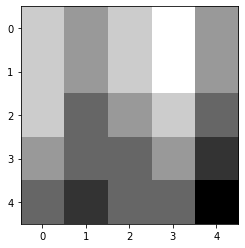

In [33]:
preds_0 = preds[1] * 255.0
preds_0 = preds_0.reshape(10, 10)
x_test_0 = x_test[1] * 255.0
x_test_0 = x_test_0.reshape(5, 5)
plt.imshow(x_test_0, cmap='gray')

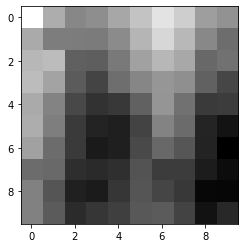

In [34]:
plt.imshow(preds_0, cmap='gray')

(5, 5)


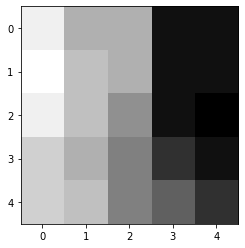

In [37]:
# plt.figure(figsize=(20,8))
plt.figure()
img = cv2.imread('./gen_data/5_gray/031_lenna.jpg', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

(10, 10)


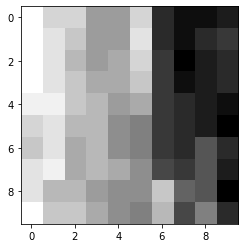

In [38]:
plt.figure()
img = cv2.imread('./gen_data/10_gray/031_lenna.jpg', 0)
plt.imshow(img, cmap='gray')
print(img.shape)